# Bias Scores for finetuned models

## Printing Functions

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

def print_bias_scores_table(data_to_plot, df, is_certainty_bias, plot_only_k_shot_zero):
    import tabulate
    if plot_only_k_shot_zero:
        if is_certainty_bias:
            # For certainty bias, print model and certainty bias score where k_shot == 0
            table_data = data_to_plot[['model', 'Certainty_Bias']]
        else:
            # For belief bias, print model and belief bias score where k_shot == 0
            table_data = data_to_plot[['model', 'Bias_Type', 'Bias_Score']]
    else:
        if is_certainty_bias:
            # For certainty bias, calculate mean and std of non-zero k_shot values
            non_zero_k_shot = df[df['k_shot'] != 0]
            table_data = non_zero_k_shot.groupby('model')['Certainty_Bias'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['model', 'Mean Certainty Bias', 'Std Dev Certainty Bias']
        else:
            # For belief bias, calculate mean and std for each Bias_Type across non-zero k_shot values
            non_zero_k_shot = data_to_plot[data_to_plot['k_shot'] != 0]
            table_data = non_zero_k_shot.groupby(['model', 'Bias_Type'])['Bias_Score'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['model', 'Bias_Type', 'Mean Bias Score', 'Std Dev Bias Score']
        # round to 2 decimal places
        table_data = table_data.round(2)

    # print a title to the table according the bias type and if we are plotting only k_shot zero
    if is_certainty_bias:
        table_title = 'Certainty Bias Scores'
    else:
        table_title = 'Belief Bias Scores'
    if plot_only_k_shot_zero:
        table_title += ' Zero-Shot'
    else:
        table_title += ' Few-Shot'
    print(table_title)

    # Print the table using tabulate
    print(tabulate.tabulate(table_data, headers='keys', tablefmt='fancy_grid'))


def plot_bias_scores(csv_file, is_certainty_bias, plot_only_k_shot_zero=True,should_print_table=True):
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Parse the bias_score column
    def parse_bias_score(x):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return float(x)

    df['parsed_bias_score'] = df['bias_score'].apply(parse_bias_score)
    
    if is_certainty_bias:
        df['Certainty_Bias'] = df['parsed_bias_score'].apply(float)
        data_to_plot = df.copy()
        if plot_only_k_shot_zero:
            data_to_plot = data_to_plot[data_to_plot['k_shot'] == 0]
    else:
        df['Belief_Valid'] = df['parsed_bias_score'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else float('nan'))
        df['Belief_Invalid'] = df['parsed_bias_score'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else float('nan'))
        
        # Reshape data to long format for plotting
        data_to_plot = pd.melt(df, id_vars=['model', 'k_shot'], 
                               value_vars=['Belief_Valid', 'Belief_Invalid'],
                               var_name='Bias_Type', value_name='Bias_Score')

        if plot_only_k_shot_zero:
            data_to_plot = data_to_plot[data_to_plot['k_shot'] == 0]

    if should_print_table:
        # print a preety table of the results before the plot, only the model, k_shot and bias score
        print_bias_scores_table(data_to_plot, df, is_certainty_bias, plot_only_k_shot_zero)

    plt.figure(figsize=(7, 4))

    if is_certainty_bias:
        title = 'Certainty Bias Score'
        y_label = 'Certainty Bias'
        sns.barplot(x='model', y='Certainty_Bias', data=data_to_plot, color='blue', errorbar='sd')
    else:
        title = 'Belief Bias Score'
        y_label = 'Bias Score'
        sns.barplot(x='model', y='Bias_Score', hue='Bias_Type', data=data_to_plot, errorbar='sd')

    # Set up the plot
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()

Belief Bias Scores Zero-Shot
╒════╤═══════════════════╤════════════════╤══════════════╕
│    │ model             │ Bias_Type      │   Bias_Score │
╞════╪═══════════════════╪════════════════╪══════════════╡
│  0 │ T5-XXL            │ Belief_Valid   │        -0.03 │
├────┼───────────────────┼────────────────┼──────────────┤
│  4 │ T5-Flan-lora-1e-4 │ Belief_Valid   │         0.09 │
├────┼───────────────────┼────────────────┼──────────────┤
│  8 │ T5-Tulu-lora-1e-4 │ Belief_Valid   │         0.11 │
├────┼───────────────────┼────────────────┼──────────────┤
│ 12 │ T5-Flan-lora-5e-5 │ Belief_Valid   │         0.12 │
├────┼───────────────────┼────────────────┼──────────────┤
│ 16 │ T5-Tulu-lora-5e-5 │ Belief_Valid   │         0.04 │
├────┼───────────────────┼────────────────┼──────────────┤
│ 20 │ Flan-T5-XXL       │ Belief_Valid   │         0.15 │
├────┼───────────────────┼────────────────┼──────────────┤
│ 24 │ T5-XXL            │ Belief_Invalid │         0.03 │
├────┼───────────────────┼─

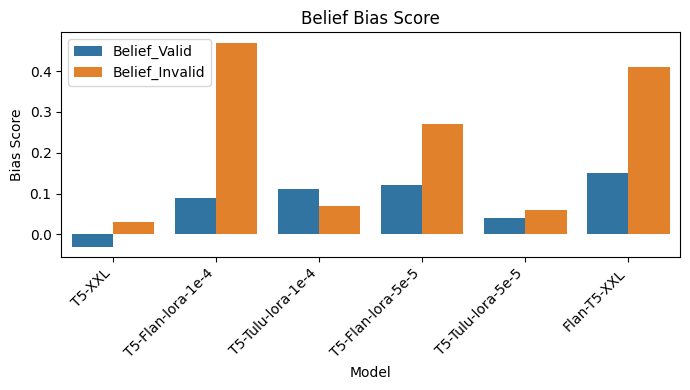

Belief Bias Scores Few-Shot
╒════╤═══════════════════╤════════════════╤═══════════════════╤══════════════════════╕
│    │ model             │ Bias_Type      │   Mean Bias Score │   Std Dev Bias Score │
╞════╪═══════════════════╪════════════════╪═══════════════════╪══════════════════════╡
│  0 │ Flan-T5-XXL       │ Belief_Invalid │              0.29 │                 0.05 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  1 │ Flan-T5-XXL       │ Belief_Valid   │              0.24 │                 0.01 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  2 │ T5-Flan-lora-1e-4 │ Belief_Invalid │              0.37 │                 0.03 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  3 │ T5-Flan-lora-1e-4 │ Belief_Valid   │              0.03 │                 0.03 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  4 │ T5-Flan-

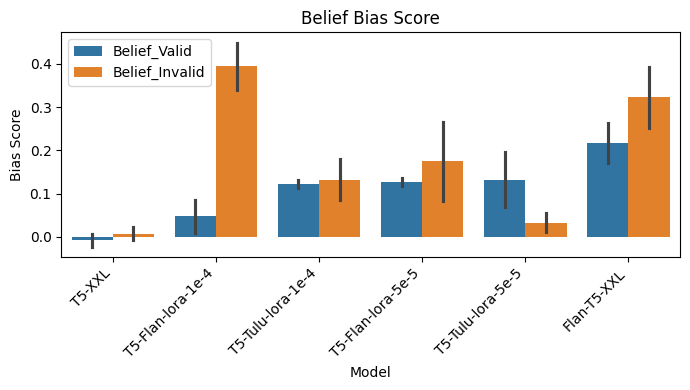

In [2]:
base_dir = '/home/itay.itzhak/projects/InstructedToBias/Predictions/'
fb_dir_base = 'false_belief/logging_aux_[1, 2, 3, 4, 5, 6, 7]_dm_full_format_True_task_False'
#belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_flan.csv'
#belief_bias_file = f'{base_dir}{fb_dir_base}_t5_flan_final_two_options.csv'
belief_bias_file = f'{base_dir}{fb_dir_base}_t5_tulu_flan.csv'
plot_bias_scores(belief_bias_file, is_certainty_bias=False, plot_only_k_shot_zero=True)
plot_bias_scores(belief_bias_file, is_certainty_bias=False, plot_only_k_shot_zero=False)

Certainty Bias Scores Zero-Shot
╒════╤═══════════════════╤══════════════════╕
│    │ model             │   Certainty_Bias │
╞════╪═══════════════════╪══════════════════╡
│  0 │ t5-v1_1-xxl       │             0.09 │
├────┼───────────────────┼──────────────────┤
│  4 │ T5-Flan-lora-1e-4 │             0.25 │
├────┼───────────────────┼──────────────────┤
│  8 │ T5-Tulu-lora-1e-4 │            -0.08 │
├────┼───────────────────┼──────────────────┤
│ 12 │ T5-Flan-lora-5e-5 │             0.11 │
├────┼───────────────────┼──────────────────┤
│ 16 │ T5-Tulu-lora-5e-5 │             0.25 │
├────┼───────────────────┼──────────────────┤
│ 20 │ flan-t5-xxl       │             0.17 │
╘════╧═══════════════════╧══════════════════╛


/tmp/ipykernel_402708/2278899370.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


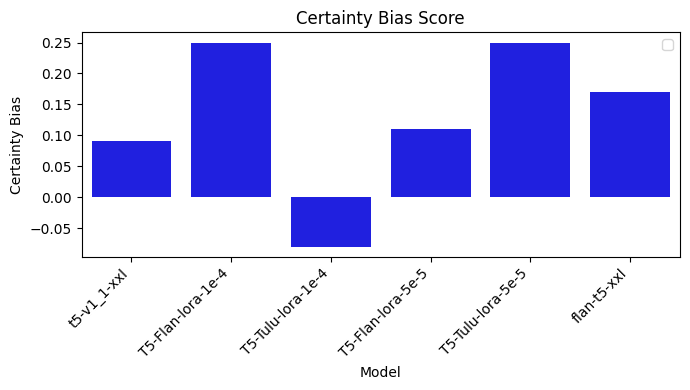

Certainty Bias Scores Few-Shot
╒════╤═══════════════════╤═══════════════════════╤══════════════════════════╕
│    │ model             │   Mean Certainty Bias │   Std Dev Certainty Bias │
╞════╪═══════════════════╪═══════════════════════╪══════════════════════════╡
│  0 │ T5-Flan-lora-1e-4 │                  0.03 │                     0.02 │
├────┼───────────────────┼───────────────────────┼──────────────────────────┤
│  1 │ T5-Flan-lora-5e-5 │                 -0.07 │                     0.03 │
├────┼───────────────────┼───────────────────────┼──────────────────────────┤
│  2 │ T5-Tulu-lora-1e-4 │                 -0.15 │                     0.06 │
├────┼───────────────────┼───────────────────────┼──────────────────────────┤
│  3 │ T5-Tulu-lora-5e-5 │                  0.2  │                     0.09 │
├────┼───────────────────┼───────────────────────┼──────────────────────────┤
│  4 │ flan-t5-xxl       │                  0.15 │                     0.03 │
├────┼───────────────────┼───────

/tmp/ipykernel_402708/2278899370.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


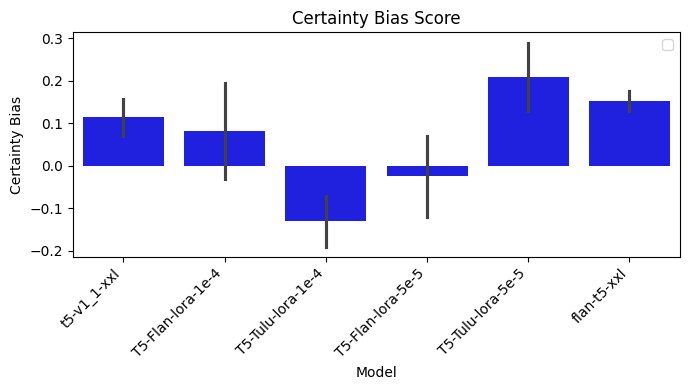

In [6]:
cer_dir_base = 'certainty/logging_aux_[1, 2, 3]_three_probs,two_probs_format_True_task_False'
#certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_flan.csv'
certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_tulu_flan.csv' 

plot_bias_scores(certainty_bias_file, is_certainty_bias=True, plot_only_k_shot_zero=True)
plot_bias_scores(certainty_bias_file, is_certainty_bias=True, plot_only_k_shot_zero=False)

## Plot Checkpoints Bias Scores

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import os
import tabulate

def print_bias_scores_table_over_steps(data_to_plot, df, is_certainty_bias, plot_only_k_shot_zero):
    if plot_only_k_shot_zero:
        # leave only k_shot == 0
        data_to_plot = data_to_plot[data_to_plot['k_shot'] == 0]
        if is_certainty_bias:
            table_data = data_to_plot[['model','step', 'Certainty_Bias']].sort_values(['model', 'step'])
            table_data.columns = ['Model', 'Training Step', 'Certainty Bias']
        else:
            # Modified to handle varying steps properly
            table_data = data_to_plot[['model', 'step', 'Bias_Type', 'Bias_Score']].sort_values(['model', 'step', 'Bias_Type'])
            table_data.columns = ['Model', 'Training Step', 'Bias Type', 'Bias Score']
    else:
        if is_certainty_bias:
            table_data = data_to_plot.groupby('model')['step', 'Certainty_Bias'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['Model', 'Training Step', 'Mean Certainty Bias', 'Std Dev Certainty Bias']
        else:
            # Modified to handle varying steps properly
            table_data = data_to_plot.groupby(['model', 'Bias_Type'])['Bias_Score'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['Model', 'Bias Type', 'Mean Bias Score', 'Std Dev Bias Score']
        table_data = table_data.round(2)

    table_title = 'Certainty Bias Scores Over Steps' if is_certainty_bias else 'Belief Bias Scores Over Steps'
    table_title += ' (Zero-Shot)' if plot_only_k_shot_zero else ' (Few-Shot)'
    print(table_title)
    print(tabulate.tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

def extract_step(model_name):
    match = re.search(r'step_step_(\d+)', model_name)
    if match:
        return int(match.group(1))
    else:
        return pd.NA

def plot_bias_scores_multiple_files(file_dict, is_certainty_bias, plot_only_k_shot_zero=True, should_print_table=True, output_dir=None, use_percentage_steps=False, random_seeds_mode=False):
    if output_dir is None:
        output_dir = os.getcwd()

    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 22,
        'axes.labelsize': 22,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 18,
        'figure.titlesize': 18
    })
    figsize = (11, 7)
    
    color_palette = sns.color_palette("colorblind", n_colors=len(file_dict) * (4 if random_seeds_mode else 1))
    unique_models = file_dict.keys()
    color_map = {model: color for model, color in zip(unique_models, color_palette)}
    
    instruction_markers = {
        'Tulu': 'o',
        'Flan': 's',
        'Other': 'D'
    }

    def get_base_model(model_name):
        if 'T5' in model_name:
            return 'T5'
        elif 'OLMo' in model_name:
            return 'OLMo'
        else:
            return 'Other'

    def get_instruction_data(model_name):
        if 'Tulu' in model_name:
            return 'Tulu'
        elif 'Flan' in model_name:
            return 'Flan'
        else:
            return 'Other'

    def get_seed(model_name):
        match = re.search(r'Seed_(\d+)', model_name)
        return match.group(1) if match else '0'

    belief_valid_data = []
    belief_invalid_data = []
    all_data = []  # For table generation

    # Create figure and axes with specified size
    fig, ax = plt.subplots(figsize=figsize)

    for name, csv_file in file_dict.items():
        df = pd.read_csv(csv_file)
        df['step'] = df['model'].apply(extract_step)
        df = df.dropna(subset=['step'])
        df['step'] = df['step'].astype(int)
        
        if use_percentage_steps:
            max_step = df['step'].max()
            df['step_percentage'] = (df['step'] / max_step) * 100

        df['parsed_bias_score'] = df['bias_score'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else float(x))
        
        base_model = get_base_model(name)
        instruction_data = get_instruction_data(name)
        seed = get_seed(name)
        unique_model_name = f"{base_model}-{instruction_data}-Seed_{seed}" if random_seeds_mode else f"{base_model}-{instruction_data}"

        color = color_map[name] if not random_seeds_mode else sns.color_palette("husl", 8)[int(seed) % 8]
        marker = instruction_markers.get(instruction_data, 'D')
        line_style = '--' if instruction_data == 'Flan' else '-'
        
        x_axis = 'step_percentage' if use_percentage_steps else 'step'
        
        # Create a copy of df for table data
        table_df = df.copy()
        
        if is_certainty_bias:
            df['Certainty_Bias'] = df['parsed_bias_score'].apply(float)
            table_df['Certainty_Bias'] = df['Certainty_Bias']  # Copy for table
            data_to_plot = df[df['k_shot'] == 0] if plot_only_k_shot_zero else df
            sns.lineplot(x=x_axis, y='Certainty_Bias', data=data_to_plot, marker=marker, 
                        label=unique_model_name, color=color, linestyle=line_style, 
                        markersize=8, linewidth=2.5, ax=ax)
        else:
            df['Belief_Valid'] = df['parsed_bias_score'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else pd.NA)
            df['Belief_Invalid'] = df['parsed_bias_score'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else pd.NA)
            table_df['Belief_Valid'] = df['Belief_Valid']  # Copy for table
            table_df['Belief_Invalid'] = df['Belief_Invalid']  # Copy for table
            df = df[df['k_shot'] == 0] if plot_only_k_shot_zero else df
            
            belief_valid_data.append(df[[x_axis, 'Belief_Valid']].assign(
                Model=unique_model_name,
                Color=[color] * len(df),
                Marker=[marker] * len(df),
                LineStyle=[line_style] * len(df)
            ))

            belief_invalid_data.append(df[[x_axis, 'Belief_Invalid']].assign(
                Model=unique_model_name,
                Color=[color] * len(df),
                Marker=[marker] * len(df),
                LineStyle=[line_style] * len(df)
            ))
        
        # Add model name to table data
        table_df['model'] = unique_model_name
        all_data.append(table_df)

    # Print table if requested
    if should_print_table:
        combined_data = pd.concat(all_data)
        if not is_certainty_bias:
            # Reshape data for belief bias table
            melted_data = pd.melt(combined_data, 
                                id_vars=['model', 'step', 'k_shot'],
                                value_vars=['Belief_Valid', 'Belief_Invalid'],
                                var_name='Bias_Type', 
                                value_name='Bias_Score')
            print_bias_scores_table_over_steps(melted_data, combined_data, is_certainty_bias, plot_only_k_shot_zero)
        else:
            print_bias_scores_table_over_steps(combined_data, combined_data, is_certainty_bias, plot_only_k_shot_zero)

    if is_certainty_bias:
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage Steps')
        ax.legend(bbox_to_anchor=(0.45, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'certainty_bias_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
    else:
        # Belief Valid Plot
        belief_valid_combined = pd.concat(belief_valid_data)
        for model_name in belief_valid_combined['Model'].unique():
            model_data = belief_valid_combined[belief_valid_combined['Model'] == model_name]
            sns.lineplot(x=x_axis, y='Belief_Valid', data=model_data, 
                        marker=model_data['Marker'].iloc[0], label=model_name, 
                        color=model_data['Color'].iloc[0], 
                        linestyle=model_data['LineStyle'].iloc[0], 
                        markersize=8, linewidth=2.5, ax=ax)
        
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        ax.set_ylabel('Belief Valid Score')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'belief_valid_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()

        # Belief Invalid Plot
        fig, ax = plt.subplots(figsize=figsize)
        belief_invalid_combined = pd.concat(belief_invalid_data)
        for model_name in belief_invalid_combined['Model'].unique():
            model_data = belief_invalid_combined[belief_invalid_combined['Model'] == model_name]
            sns.lineplot(x=x_axis, y='Belief_Invalid', data=model_data, 
                        marker=model_data['Marker'].iloc[0], label=model_name, 
                        color=model_data['Color'].iloc[0], 
                        linestyle=model_data['LineStyle'].iloc[0], 
                        markersize=8, linewidth=2.5, ax=ax)
        
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        ax.set_ylabel('Belief Invalid Score')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'belief_invalid_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()




base_dir = '/home/itay.itzhak/projects/InstructedToBias/Predictions/'
cer_dir_base = 'certainty/logging_aux_[1, 2, 3]_three_probs,two_probs_format_True_task_False'
fb_dir_base = 'false_belief/logging_aux_[1, 2, 3, 4, 5, 6, 7]_dm_full_format_True_task_False'

Certainty Bias Scores Over Steps (Zero-Shot)
╒═════╤════════════════╤═════════════════╤══════════════════╕
│     │ Model          │   Training Step │   Certainty Bias │
╞═════╪════════════════╪═════════════════╪══════════════════╡
│   0 │ T5-Tulu-Seed_0 │             500 │             0.33 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│   4 │ T5-Tulu-Seed_0 │            1000 │             0.72 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│   8 │ T5-Tulu-Seed_0 │            1500 │             0.67 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│  12 │ T5-Tulu-Seed_0 │            2000 │            -0.14 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│  16 │ T5-Tulu-Seed_0 │            2500 │             0.51 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│  20 │ T5-Tulu-Seed_0 │            3000 │             0.12 │
├─────┼────────────────┼─────────────────┼──────────────────┤
│  24 │ T5-Tulu-Seed_0 │ 

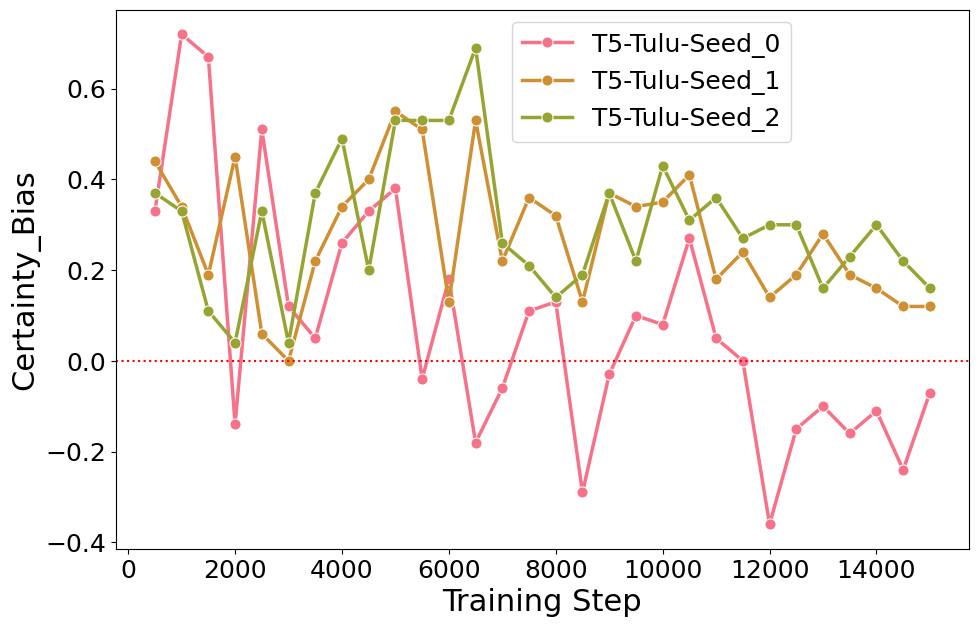

In [61]:
# T5-Tulu
t5_tulu_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_tulu_checkpoints.csv'
t5_tulu_seed_1_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_tulu_seed_1.csv'
t5_tulu_seed_2_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_tulu_seed_2.csv'
# OLMo-Flan
olmo_flan_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_flan_checkpoints.csv'
olmo_flan_seed_1_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_flan_seed_1_checkpoints.csv'
olmo_flan_seed_2_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_flan_seed_2_checkpoints.csv'
# OLMo-Tulu
olmo_tulu_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_tulu_checkpoints.csv' 
olmo_tulu_seed_1_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_tulu_seed_1_checkpoints_partial.csv' # need to run more steps
olmo_tulu_seed_2_certainty_bias_file = f'{base_dir}{cer_dir_base}_olmo_tulu_seed_2_checkpoints_partial.csv' # need to run more steps
# T5-Flan
t5_flan_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_flan_checkpoints.csv'
t5_flan_seed_1_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_flan_seed_1.csv'
t5_flan_seed_2_certainty_bias_file = f'{base_dir}{cer_dir_base}_t5_flan_seed_2.csv'

# Dictionary of short names and corresponding CSV file paths
file_dict = {
    # OLMo-Tulu
    #'OLMo-Tulu': olmo_tulu_certainty_bias_file,
    #'OLMo-Tulu-Seed_1': olmo_tulu_seed_1_certainty_bias_file,
    #'OLMo-Tulu-Seed_2': olmo_tulu_seed_2_certainty_bias_file,
    # OLMo-Flan
    #'OLMo-Flan': olmo_flan_certainty_bias_file,
    #'OLMo-Flan-Seed_1': olmo_flan_seed_1_certainty_bias_file,
    #'OLMo-Flan-Seed_2': olmo_flan_seed_2_certainty_bias_file,
    # T5-Flan
    # 'T5-Flan': t5_flan_certainty_bias_file,
    # 'T5-Flan-Seed_1': t5_flan_seed_1_certainty_bias_file, # don't have this yet
    # 'T5-Flan-Seed_2': t5_flan_seed_2_certainty_bias_file, # don't have this yet
    # T5-Tulu
    'T5-Tulu': t5_tulu_certainty_bias_file,
    'T5-Tulu-Seed_1': t5_tulu_seed_1_certainty_bias_file,
    'T5-Tulu-Seed_2': t5_tulu_seed_2_certainty_bias_file,
}

# Plot Certainty Bias over training steps for multiple files (Zero-Shot)
# plot_bias_scores_multiple_files(
#     file_dict=file_dict,
#     is_certainty_bias=True,
#     plot_only_k_shot_zero=True,
#     should_print_table=False,
#     #use_percentage_steps=True,
#     use_percentage_steps=False,
# )

# Plot Certainty over training steps for multiple files (Few-Shot)
# plot_bias_scores_multiple_files(
#     file_dict=file_dict,
#     is_certainty_bias=True,
#     plot_only_k_shot_zero=False,
#     should_print_table=False,
#     use_percentage_steps=True,
# )

# Plot Certainty over training steps for multiple files with random seeds (Zero-Shot)
plot_bias_scores_multiple_files(
    file_dict=file_dict,
    is_certainty_bias=True,
    plot_only_k_shot_zero=True,
    should_print_table=True,
    use_percentage_steps=False,
    random_seeds_mode=True,
)

Belief Bias Scores Over Steps (Zero-Shot)
╒═════╤════════════════╤═════════════════╤════════════════╤══════════════╕
│     │ Model          │   Training Step │ Bias Type      │   Bias Score │
╞═════╪════════════════╪═════════════════╪════════════════╪══════════════╡
│ 352 │ T5-Tulu-Seed_0 │             500 │ Belief_Invalid │        -0    │
├─────┼────────────────┼─────────────────┼────────────────┼──────────────┤
│   0 │ T5-Tulu-Seed_0 │             500 │ Belief_Valid   │         0.01 │
├─────┼────────────────┼─────────────────┼────────────────┼──────────────┤
│ 356 │ T5-Tulu-Seed_0 │            1000 │ Belief_Invalid │        -0.02 │
├─────┼────────────────┼─────────────────┼────────────────┼──────────────┤
│   4 │ T5-Tulu-Seed_0 │            1000 │ Belief_Valid   │        -0.02 │
├─────┼────────────────┼─────────────────┼────────────────┼──────────────┤
│ 360 │ T5-Tulu-Seed_0 │            1500 │ Belief_Invalid │         0.11 │
├─────┼────────────────┼─────────────────┼────────────────

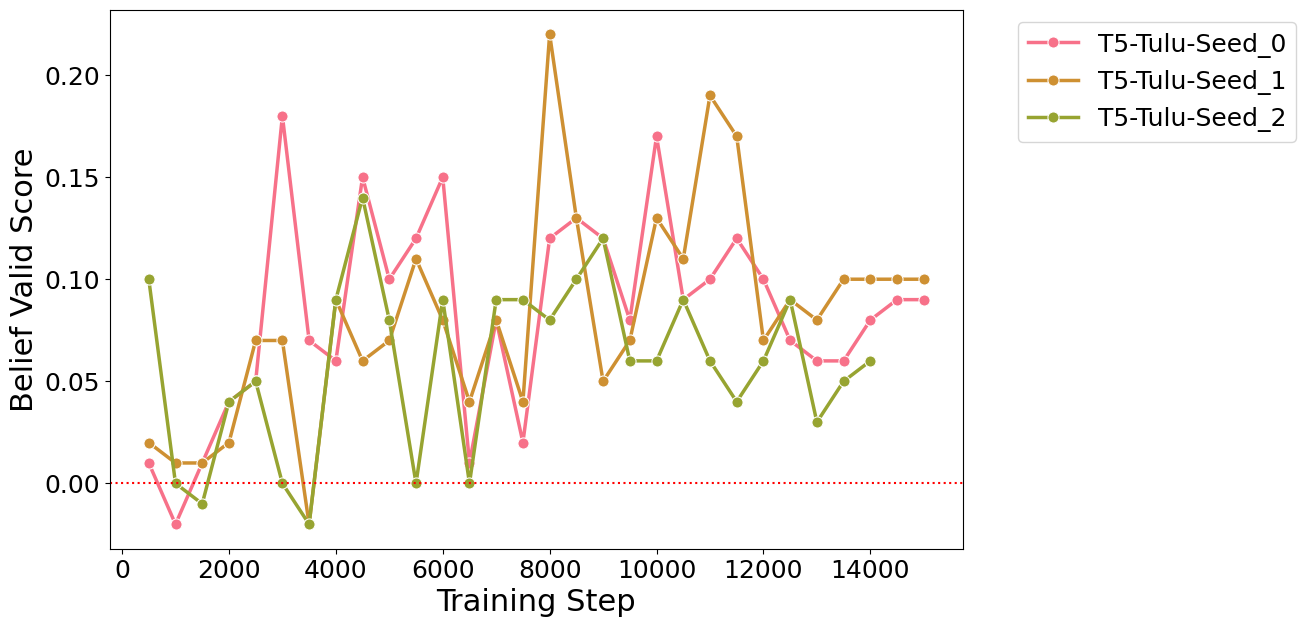

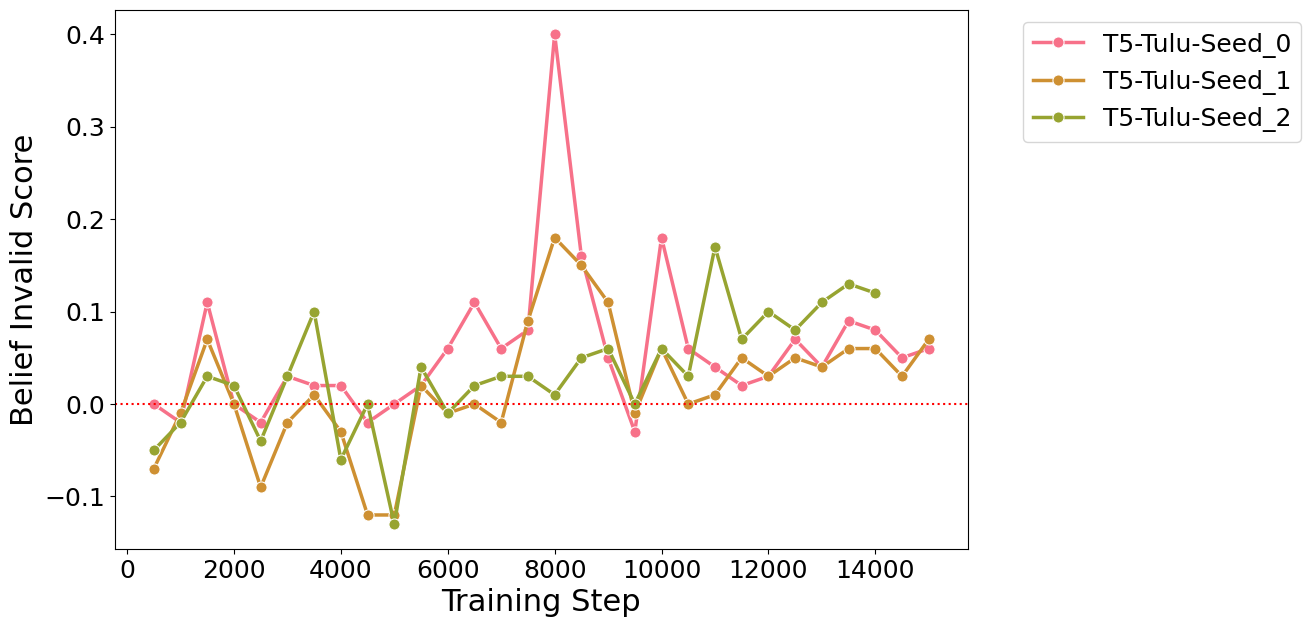

In [64]:
# Belief Bias
# T5-Tulu
t5_tulu_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_tulu_checkpoints.csv'
t5_tulu_seed_1_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_tulu_seed_1.csv'
t5_tulu_seed_2_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_tulu_seed_2.csv'
# OLMo-Flan
olmo_flan_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_flan_checkpoints.csv'
olmo_flan_seed_1_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_flan_seed_1_checkpoints.csv'
olmo_flan_seed_2_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_flan_seed_2_checkpoints.csv'
# OLMo-Tulu
olmo_tulu_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_tulu_checkpoints.csv' 
olmo_tulu_seed_1_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_tulu_seed_1_checkpoints_partial.csv' # need to run more steps
olmo_tulu_seed_2_belief_bias_file = f'{base_dir}{fb_dir_base}_olmo_tulu_seed_2_checkpoints_partial.csv' # need to run more steps
# T5-Flan
t5_flan_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_flan_checkpoints.csv'
t5_flan_seed_1_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_flan_seed_1.csv'
t5_flan_seed_2_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_flan_seed_2.csv'

t5_flan_belief_bias_file = f'{base_dir}{fb_dir_base}_t5_flan_checkpoints.csv'



# Dictionary of short names and corresponding CSV file paths
file_dict = {
    #'OLMo-Tulu': olmo_tulu_belief_bias_file,
    #'OLMo-Tulu-Seed_1': olmo_tulu_seed_1_belief_bias_file,
    #'OLMo-Tulu-Seed_2': olmo_tulu_seed_2_belief_bias_file,
    #'OLMo-Flan': olmo_flan_belief_bias_file,
    #'OLMo-Flan-Seed_1': olmo_flan_seed_1_belief_bias_file,
    #'OLMo-Flan-Seed_2': olmo_flan_seed_2_belief_bias_file,
    #'T5-Flan': t5_flan_belief_bias_file,
    'T5-Tulu': t5_tulu_belief_bias_file,
    'T5-Tulu-Seed_1': t5_tulu_seed_1_belief_bias_file,
    'T5-Tulu-Seed_2': t5_tulu_seed_2_belief_bias_file,
}

# Plot Bias over training steps for multiple files (Zero-Shot)
# plot_bias_scores_multiple_files(
#     file_dict=file_dict,
#     is_certainty_bias=False,
#     plot_only_k_shot_zero=True,
#     should_print_table=False,
#     use_percentage_steps=False,#True,
# )

# Plot Bias over training steps for multiple files (Few-Shot)
# plot_bias_scores_multiple_files(
#     file_dict=file_dict,
#     is_certainty_bias=False,
#     plot_only_k_shot_zero=False,
#     should_print_table=False,
#     use_percentage_steps=True,
# )

# Plot Bias over training steps for multiple files with random seeds (Zero-Shot)
plot_bias_scores_multiple_files(
    file_dict=file_dict,
    is_certainty_bias=False,
    plot_only_k_shot_zero=True,
    should_print_table=True,
    use_percentage_steps=False,
    random_seeds_mode=True,
)

In [ ]:
## OLD CODE Before adding print table ###
### Delete if working ###

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import os
import tabulate

def print_bias_scores_table_over_steps(data_to_plot, df, is_certainty_bias, plot_only_k_shot_zero):
    if plot_only_k_shot_zero:
        if is_certainty_bias:
            table_data = data_to_plot[['step', 'Certainty_Bias']].sort_values('step')
            table_data.columns = ['Training Step', 'Certainty Bias']
        else:
            table_data = data_to_plot[['step', 'Bias_Type', 'Bias_Score']].sort_values('step')
            table_data.columns = ['Training Step', 'Bias Type', 'Bias Score']
    else:
        if is_certainty_bias:
            table_data = data_to_plot.groupby('step')['Certainty_Bias'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['Training Step', 'Mean Certainty Bias', 'Std Dev Certainty Bias']
        else:
            table_data = data_to_plot.groupby(['step', 'Bias_Type'])['Bias_Score'].agg(['mean', 'std']).reset_index()
            table_data.columns = ['Training Step', 'Bias Type', 'Mean Bias Score', 'Std Dev Bias Score']
        table_data = table_data.round(2)

    table_title = 'Certainty Bias Scores Over Steps' if is_certainty_bias else 'Belief Bias Scores Over Steps'
    table_title += ' (Zero-Shot)' if plot_only_k_shot_zero else ' (Few-Shot)'
    print(table_title)
    print(tabulate.tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

def extract_step(model_name):
    match = re.search(r'step_step_(\d+)', model_name)
    if match:
        return int(match.group(1))
    else:
        return pd.NA

def plot_bias_scores_multiple_files(file_dict, is_certainty_bias, plot_only_k_shot_zero=True, should_print_table=True, output_dir=None, use_percentage_steps=False, random_seeds_mode=False):
    if output_dir is None:
        output_dir = os.getcwd()

    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 22,
        'axes.labelsize': 22,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 18,
        'figure.titlesize': 18
    })
    figsize = (11, 7)
    

    color_palette = sns.color_palette("colorblind", n_colors=len(file_dict) * (4 if random_seeds_mode else 1))
    unique_models = file_dict.keys()
    color_map = {model: color for model, color in zip(unique_models, color_palette)}
    
    instruction_markers = {
        'Tulu': 'o',
        'Flan': 's',
        'Other': 'D'
    }

    def get_base_model(model_name):
        if 'T5' in model_name:
            return 'T5'
        elif 'OLMo' in model_name:
            return 'OLMo'
        else:
            return 'Other'

    def get_instruction_data(model_name):
        if 'Tulu' in model_name:
            return 'Tulu'
        elif 'Flan' in model_name:
            return 'Flan'
        else:
            return 'Other'

    def get_seed(model_name):
        match = re.search(r'Seed_(\d+)', model_name)
        return match.group(1) if match else '0'

    belief_valid_data = []
    belief_invalid_data = []

    # Create figure and axes with specified size
    
    fig, ax = plt.subplots(figsize=figsize)

    for name, csv_file in file_dict.items():
        df = pd.read_csv(csv_file)
        df['step'] = df['model'].apply(extract_step)
        df = df.dropna(subset=['step'])
        df['step'] = df['step'].astype(int)
        
        if use_percentage_steps:
            max_step = df['step'].max()
            df['step_percentage'] = (df['step'] / max_step) * 100

        df['parsed_bias_score'] = df['bias_score'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else float(x))
        
        base_model = get_base_model(name)
        instruction_data = get_instruction_data(name)
        seed = get_seed(name)
        unique_model_name = f"{base_model}-{instruction_data}-Seed_{seed}" if random_seeds_mode else f"{base_model}-{instruction_data}"

        color = color_map[name] if not random_seeds_mode else sns.color_palette("husl", 8)[int(seed) % 8]
        marker = instruction_markers.get(instruction_data, 'D')
        line_style = '--' if instruction_data == 'Flan' else '-'
        
        x_axis = 'step_percentage' if use_percentage_steps else 'step'
        
        if is_certainty_bias:
            df['Certainty_Bias'] = df['parsed_bias_score'].apply(float)
            data_to_plot = df[df['k_shot'] == 0] if plot_only_k_shot_zero else df
            #sns.lineplot(x=x_axis, y='Certainty_Bias', data=data_to_plot, marker=marker, label=unique_model_name, color=color, linestyle=line_style, markersize=8, linewidth=2.5)
            sns.lineplot(x=x_axis, y='Certainty_Bias', data=data_to_plot, marker=marker, label=unique_model_name, color=color, linestyle=line_style, markersize=8, linewidth=2.5, ax=ax)
        else:
            df['Belief_Valid'] = df['parsed_bias_score'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else pd.NA)
            df['Belief_Invalid'] = df['parsed_bias_score'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else pd.NA)
            df = df[df['k_shot'] == 0] if plot_only_k_shot_zero else df
            
            belief_valid_data.append(df[[x_axis, 'Belief_Valid']].assign(
                Model=unique_model_name,
                Color=[color] * len(df),
                Marker=[marker] * len(df),
                LineStyle=[line_style] * len(df)
            ))

            belief_invalid_data.append(df[[x_axis, 'Belief_Invalid']].assign(
                Model=unique_model_name,
                Color=[color] * len(df),
                Marker=[marker] * len(df),
                LineStyle=[line_style] * len(df)
            ))

    if is_certainty_bias:
        # plt.axhline(0, color='red', linestyle='dotted')
        # plt.xlabel('Training Step' if not use_percentage_steps else 'Percentage Steps')
        # plt.legend(bbox_to_anchor=(0.45, 1), loc='upper left')
        # plt.savefig(os.path.join(output_dir, 'certainty_bias_plot.pdf'), format='pdf', bbox_inches='tight')
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage Steps')
        ax.legend(bbox_to_anchor=(0.45, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'certainty_bias_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
    else:
        # Belief Valid Plot
        
        belief_valid_combined = pd.concat(belief_valid_data)
        for model_name in belief_valid_combined['Model'].unique():
            model_data = belief_valid_combined[belief_valid_combined['Model'] == model_name]
            #sns.lineplot(x=x_axis, y='Belief_Valid', data=model_data, marker=model_data['Marker'].iloc[0], label=model_name, color=model_data['Color'].iloc[0], linestyle=model_data['LineStyle'].iloc[0], markersize=8, linewidth=2.5)
            sns.lineplot(x=x_axis, y='Belief_Valid', data=model_data, marker=model_data['Marker'].iloc[0], label=model_name, color=model_data['Color'].iloc[0], linestyle=model_data['LineStyle'].iloc[0], markersize=8, linewidth=2.5, ax=ax)
        
        # plt.axhline(0, color='red', linestyle='dotted')
        # plt.xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        # plt.ylabel('Belief Valid Score')
        # plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
        # plt.savefig(os.path.join(output_dir, 'belief_valid_plot.pdf'), format='pdf', bbox_inches='tight')
        # plt.show()
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        ax.set_ylabel('Belief Valid Score')
        #ax.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'belief_valid_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()

        # Belief Invalid Plot
        fig, ax = plt.subplots(figsize=figsize)
        belief_invalid_combined = pd.concat(belief_invalid_data)
        for model_name in belief_invalid_combined['Model'].unique():
            model_data = belief_invalid_combined[belief_invalid_combined['Model'] == model_name]
            #sns.lineplot(x=x_axis, y='Belief_Invalid', data=model_data, marker=model_data['Marker'].iloc[0], label=model_name, color=model_data['Color'].iloc[0], linestyle=model_data['LineStyle'].iloc[0], markersize=8, linewidth=2.5)
            sns.lineplot(x=x_axis, y='Belief_Invalid', data=model_data, marker=model_data['Marker'].iloc[0], label=model_name, color=model_data['Color'].iloc[0], linestyle=model_data['LineStyle'].iloc[0], markersize=8, linewidth=2.5, ax=ax)
        
        # plt.axhline(0, color='red', linestyle='dotted')
        # plt.xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        # plt.ylabel('Belief Invalid Score')
        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # plt.savefig(os.path.join(output_dir, 'belief_invalid_plot.pdf'), format='pdf', bbox_inches='tight')
        # plt.show()
        ax.axhline(0, color='red', linestyle='dotted')
        ax.set_xlabel('Training Step' if not use_percentage_steps else 'Percentage of Steps')
        ax.set_ylabel('Belief Invalid Score')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(os.path.join(output_dir, 'belief_invalid_plot.pdf'), format='pdf', bbox_inches='tight')
        plt.show()




base_dir = '/home/itay.itzhak/projects/InstructedToBias/Predictions/'
cer_dir_base = 'certainty/logging_aux_[1, 2, 3]_three_probs,two_probs_format_True_task_False'
fb_dir_base = 'false_belief/logging_aux_[1, 2, 3, 4, 5, 6, 7]_dm_full_format_True_task_False'
